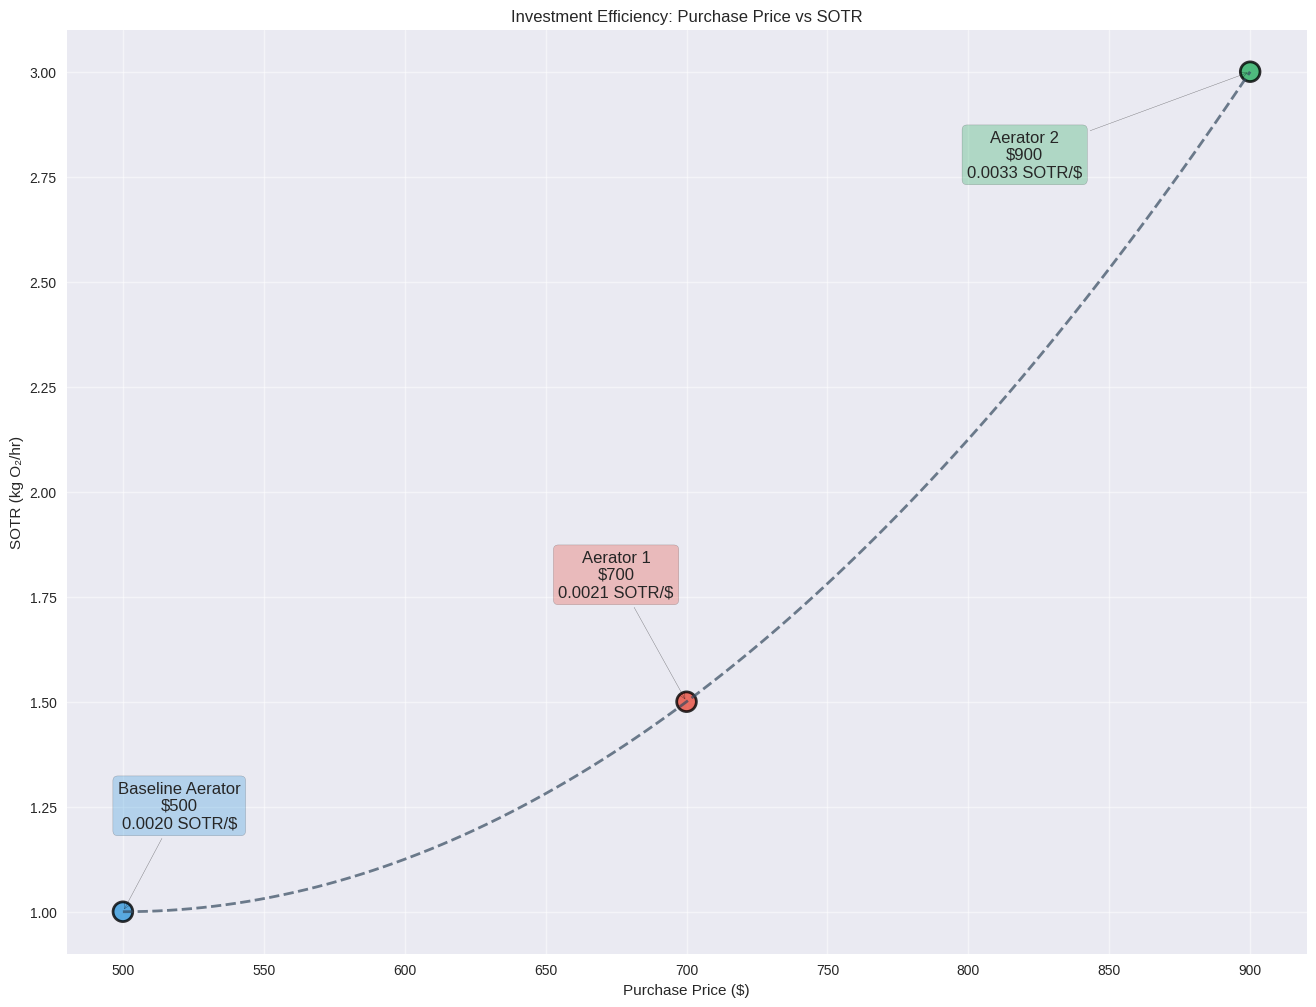

Aerator,SOTR (kg O₂/hr),Price ($),Annual Production (kg O₂/year),Cost Efficiency ($/kg O₂),Cost per SOTR ($/SOTR),SOTR per Dollar
Baseline Aerator,1.0,$500,"1,918",$0.170,$500,0.0020
Aerator 1,1.5,$700,"2,877",$0.114,$467,0.0021
Aerator 2,3.0,$900,"5,753",$0.057,$300,0.0033


Upgrade Path,Additional Investment ($),SOTR Gain (kg O₂/hr),Production Gain (kg O₂/year),SOTR per Dollar,Production per Dollar (kg O₂/year/$)
Baseline Aerator → to → Aerator 1,$200,0.5,959,0.0025,4.8
Aerator 1 → to → Aerator 2,$200,1.5,"2,877",0.0075,14.4


In [48]:
"""
Aerator Performance Analysis and Visualization Module

This module provides analysis and visualization tools for comparing
aerator performance in aquaculture applications. It calculates metrics including
oxygen transfer rates, energy efficiency, and marginal economic returns.

Key Features:
- Temperature-adjusted oxygen transfer rate (OTRT) calculations
- Standard aeration efficiency (SAE) analysis
- Marginal investment analysis for equipment comparison
- Interactive and static visualizations
- Economic performance summary tables

Author: Luis Paulo Vinatea Barberena
Date: 2025-01-20
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline
from IPython.display import display, HTML

# Set style for professional plots
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

# Define consistent colors for each aerator type
colors = {
    "Baseline Aerator": "#3498db",  # Blue
    "Aerator 1": "#e74c3c",  # Red
    "Aerator 2": "#27ae60",  # Green
}

# ============================ CONSTANTS AND PARAMETERS =================================

# Temperature correction factor for oxygen transfer (standard value for aquaculture)
theta = 1.024
# Standard temperature for SOTR measurements (20°C)
standard_temp = 20
# Actual farm operating temperature (°C)
farm_temp = 31.5
# Energy cost per kilowatt-hour ($/kWh)
energy_cost_per_kwh = 0.05
# Daily aerator operation hours
daily_operation_hours = 8
# Days per year for annual calculations
days_per_year = 365

# Aerator specifications: SOTR (kg O₂/hr) and purchase price ($)
aerator_specs = {
    "Baseline Aerator": {"sotr": 1.0, "price": 500},
    "Aerator 1": {"sotr": 1.5, "price": 700},
    "Aerator 2": {"sotr": 3.0, "price": 900},
}

# Standard aerator power rating
power_hp = 3  # Horsepower
power_kw = power_hp * 0.746  # Convert to kilowatts


# ============================== CALCULATION FUNCTIONS ==================================


def calculate_otrt(sotr, temp):
    """
    Calculate Temperature-Adjusted Oxygen Transfer Rate (OTRT).

    The OTRT adjusts the Standard Oxygen Transfer Rate (SOTR) for actual
    operating temperature using the van't Hoff-Arrhenius relationship.

    Parameters:
    -----------
    sotr : float
        Standard Oxygen Transfer Rate at 20°C (kg O₂/hr)
    temp : float
        Operating temperature (°C)

    Returns:
    --------
    float
        Temperature-adjusted oxygen transfer rate (kg O₂/hr)

    Formula:
    --------
    OTRT = (SOTR × 0.5) × θ^(T-20)
    where θ = 1.024 (temperature correction factor)
    """
    return (sotr * 0.5) * (theta ** (temp - standard_temp))


def calculate_sae(sotr, power_kw):
    """
    Calculate Standard Aeration Efficiency (SAE).

    SAE measures the oxygen transfer capability per unit of energy consumed,
    providing a metric for energy efficiency comparison.

    Parameters:
    -----------
    sotr : float
        Standard Oxygen Transfer Rate (kg O₂/hr)
    power_kw : float
        Power consumption in kilowatts

    Returns:
    --------
    float
        Standard Aeration Efficiency (kg O₂/kWh)
    """
    return sotr / power_kw


def calculate_daily_metrics(otrt, power_kw, hours):
    """
    Calculate comprehensive daily performance metrics for aerators.

    This function computes daily oxygen production, energy consumption,
    operating costs, and cost efficiency metrics.

    Parameters:
    -----------
    otrt : float
        Temperature-adjusted oxygen transfer rate (kg O₂/hr)
    power_kw : float
        Power consumption in kilowatts
    hours : int
        Daily operation hours

    Returns:
    --------
    tuple
        (daily_o2_transfer, daily_energy_consumption,
         daily_energy_cost, cost_per_kg_o2)
    """
    # Calculate total daily oxygen production
    daily_o2_transfer = otrt * hours

    # Calculate total daily energy consumption
    daily_energy_consumption = power_kw * hours

    # Calculate daily energy cost
    daily_energy_cost = daily_energy_consumption * energy_cost_per_kwh

    # Calculate cost efficiency ($/kg O₂)
    cost_per_kg_o2 = (
        daily_energy_cost / daily_o2_transfer if daily_o2_transfer > 0 else 0
    )

    return (
        daily_o2_transfer,
        daily_energy_consumption,
        daily_energy_cost,
        cost_per_kg_o2,
    )


# ================================ DATA PROCESSING ======================================

# Extract aerator names for consistent ordering
aerator_names = list(aerator_specs.keys())

# Initialize dictionary to store performance data
performance_data = {}

# Process each aerator to calculate performance metrics
for name, specs in aerator_specs.items():
    sotr = specs["sotr"]
    price = specs["price"]

    # Calculate temperature-adjusted metrics
    otrt = calculate_otrt(sotr, farm_temp)
    sae = calculate_sae(sotr, power_kw)

    # Calculate daily performance metrics
    daily_metrics = calculate_daily_metrics(
        otrt, power_kw, daily_operation_hours
    )

    # Store performance data
    performance_data[name] = {
        "sotr": sotr,
        "price": price,
        "otrt": otrt,
        "sae": sae,
        "daily_o2": daily_metrics[0],
        "daily_energy": daily_metrics[1],
        "daily_cost": daily_metrics[2],
        "cost_per_kg_o2": daily_metrics[3],
        "annual_o2": daily_metrics[0] * days_per_year,
        "cost_per_sotr": price / sotr,  # Investment efficiency metric
        "sotr_per_dollar": sotr / price,  # Performance per dollar invested
    }

# Extract data arrays for plotting and analysis
sotr_values = [performance_data[name]["sotr"] for name in aerator_names]
otrt_values = [performance_data[name]["otrt"] for name in aerator_names]
sae_values = [performance_data[name]["sae"] for name in aerator_names]
daily_o2_values = [
    performance_data[name]["daily_o2"] for name in aerator_names
]
cost_per_kg_o2_values = [
    performance_data[name]["cost_per_kg_o2"] for name in aerator_names
]
annual_o2_production = [
    performance_data[name]["annual_o2"] for name in aerator_names
]
prices = [performance_data[name]["price"] for name in aerator_names]
sotr_per_dollar = [
    performance_data[name]["sotr_per_dollar"] for name in aerator_names
]


# =========================== MARGINAL ANALYSIS =========================================


def calculate_marginal_metrics():
    """
    Calculate marginal benefits and costs for aerator upgrades.

    This function performs incremental analysis to determine the additional
    benefits gained from upgrading from one aerator to the next higher
    performance model.

    Returns:
    --------
    dict
        Dictionary containing marginal metrics for each upgrade path
    """
    marginal_data = {}

    # Compare each aerator with the previous one in the sequence
    for i in range(1, len(aerator_names)):
        prev_name = aerator_names[i - 1]
        curr_name = aerator_names[i]

        # Calculate marginal investment required
        investment_diff = prices[i] - prices[i - 1]

        # Calculate marginal performance gains
        sotr_diff = sotr_values[i] - sotr_values[i - 1]
        production_diff = annual_o2_production[i] - annual_o2_production[i - 1]
        cost_efficiency_diff = (
            cost_per_kg_o2_values[i - 1] - cost_per_kg_o2_values[i]
        )

        # Store marginal analysis results
        marginal_data[f"{prev_name}_to_{curr_name}"] = {
            "investment_diff": investment_diff,
            "sotr_diff": sotr_diff,
            "production_diff": production_diff,
            "cost_efficiency_diff": cost_efficiency_diff,
            "sotr_per_dollar": sotr_diff / investment_diff,
            "production_per_dollar": production_diff / investment_diff,
            "efficiency_per_dollar": cost_efficiency_diff / investment_diff,
            "productivity_per_sotr": production_diff / sotr_diff,
        }

    return marginal_data


# Calculate marginal metrics for all upgrade paths
marginal_metrics = calculate_marginal_metrics()


# =========================== PLOTTING FUNCTIONS ======================================


def create_smooth_curve(x_data, y_data, num_points=100):
    """
    Create smooth interpolated curves for plotting.

    Uses B-spline interpolation to create smooth trend lines through
    discrete data points for better visualization.

    Parameters:
    -----------
    x_data : list
        X-axis data points
    y_data : list
        Y-axis data points
    num_points : int, optional
        Number of points in the smooth curve (default: 100)

    Returns:
    --------
    tuple
        (x_smooth, y_smooth) arrays or (None, None) if insufficient data
    """
    if len(x_data) >= 3:
        # Sort data by x values to ensure monotonic sequence for interpolation
        sorted_indices = np.argsort(x_data)
        x_sorted = np.array(x_data)[sorted_indices]
        y_sorted = np.array(y_data)[sorted_indices]

        # Create smooth interpolation
        x_smooth = np.linspace(min(x_sorted), max(x_sorted), num_points)
        spl = make_interp_spline(x_sorted, y_sorted, k=2)
        y_smooth = spl(x_smooth)
        return x_smooth, y_smooth
    return None, None


def plot_price_vs_sotr():
    """
    Create scatter plot of aerator price vs SOTR performance.

    This visualization helps identify the most cost-effective aerators
    by showing the relationship between investment and performance.

    Returns:
    --------
    tuple
        (figure, axes) matplotlib objects
    """
    fig, ax = plt.subplots(figsize=(16, 12))

    # Create scatter plot with custom colors and styling
    ax.scatter(
        prices,
        sotr_values,
        s=200,  # Point size
        c=[colors[name] for name in aerator_names],  # Custom colors
        edgecolors="black",
        linewidth=2,
        alpha=0.8,
    )

    # Add smooth trend line if possible
    x_smooth, y_smooth = create_smooth_curve(prices, sotr_values)
    if x_smooth is not None:
        ax.plot(
            x_smooth, y_smooth, "--", color="#34495e", linewidth=2, alpha=0.7
        )

    # Manual annotation positioning with xy coordinates for clarity
    annotation_positions = [
        (500, 1.0, (520, 1.2)),  # Baseline Aerator
        (700, 1.5, (675, 1.75)),  # Aerator 1
        (900, 3.0, (820, 2.75)),  # Aerator 2
    ]

    # Add informative annotations for each aerator
    for i, (x, y, (ann_x, ann_y)) in enumerate(annotation_positions):
        name = aerator_names[i]
        ax.annotate(
            f"{name}\n${prices[i]}\n{sotr_per_dollar[i]:.4f} SOTR/$",
            xy=(x, y),
            xytext=(ann_x, ann_y),
            fontsize=12,
            ha="center",
            bbox=dict(boxstyle="round", facecolor=colors[name], alpha=0.3),
            arrowprops=dict(arrowstyle="->", color="black", alpha=0.5),
        )

    # Customize plot appearance
    ax.set_xlabel("Purchase Price ($)")
    ax.set_ylabel("SOTR (kg O₂/hr)")
    ax.set_title("Investment Efficiency: Purchase Price vs SOTR")
    ax.grid(True, alpha=0.5)
    return fig, ax


# =========================== MAIN EXECUTION ============================================

# Generate the main visualization
fig2, ax2 = plot_price_vs_sotr()
plt.show()

# ========================= HTML TABLE GENERATION =====================================

# Create HTML table for performance summary
html_performance = """
<h2>AERATOR PERFORMANCE SUMMARY</h2>
<table border="1" style="border-collapse: collapse; width: 100%; margin: 20px 0;">
<thead>
<tr style="background-color: transparent;">
<th style="padding: 12px; text-align: left;">Aerator</th>
<th style="padding: 12px; text-align: center;">SOTR (kg O₂/hr)</th>
<th style="padding: 12px; text-align: center;">Price ($)</th>
<th style="padding: 12px; text-align: center;">Annual Production (kg O₂/year)</th>
<th style="padding: 12px; text-align: center;">Cost Efficiency ($/kg O₂)</th>
<th style="padding: 12px; text-align: center;">Cost per SOTR ($/SOTR)</th>
<th style="padding: 12px; text-align: center;">SOTR per Dollar</th>
</tr>
</thead>
<tbody>
"""

# Populate performance table with calculated data
for name in aerator_names:
    data = performance_data[name]
    html_performance += f"""
<tr>
<td style="padding: 12px; font-weight: bold;">{name}</td>
<td style="padding: 12px; text-align: center;">{data["sotr"]:.1f}</td>
<td style="padding: 12px; text-align: center;">${data["price"]:,}</td>
<td style="padding: 12px; text-align: center;">{data["annual_o2"]:,.0f}</td>
<td style="padding: 12px; text-align: center;">${data["cost_per_kg_o2"]:.3f}</td>
<td style="padding: 12px; text-align: center;">${data["cost_per_sotr"]:.0f}</td>
<td style="padding: 12px; text-align: center;">{data["sotr_per_dollar"]:.4f}</td>
</tr>
"""

html_performance += """
</tbody>
</table>
"""

# Create HTML table for marginal analysis results
html_marginal = """
<h2>MARGINAL ANALYSIS</h2>
<table border="1" style="border-collapse: collapse; width: 100%; margin: 20px 0;">
<thead>
<tr style="background-color: transparent;">
<th style="padding: 12px; text-align: left;">Upgrade Path</th>
<th style="padding: 12px; text-align: center;">Additional Investment ($)</th>
<th style="padding: 12px; text-align: center;">SOTR Gain (kg O₂/hr)</th>
<th style="padding: 12px; text-align: center;">Production Gain (kg O₂/year)</th>
<th style="padding: 12px; text-align: center;">SOTR per Dollar</th>
<th style="padding: 12px; text-align: center;">Production per Dollar (kg O₂/year/$)</th>
</tr>
</thead>
<tbody>
"""

# Populate marginal analysis table
for key, metrics in marginal_metrics.items():
    # Format upgrade path name for display
    upgrade_path = key.replace("_", " → ").replace("Aerator", "Aerator")
    html_marginal += f"""
<tr>
<td style="padding: 12px; font-weight: bold;">{upgrade_path}</td>
<td style="padding: 12px; text-align: center;">${metrics["investment_diff"]:,}</td>
<td style="padding: 12px; text-align: center;">{metrics["sotr_diff"]:.1f}</td>
<td style="padding: 12px; text-align: center;">{metrics["production_diff"]:,.0f}</td>
<td style="padding: 12px; text-align: center;">{metrics["sotr_per_dollar"]:.4f}</td>
<td style="padding: 12px; text-align: center;">{metrics["production_per_dollar"]:.1f}</td>
</tr>
"""

html_marginal += """
</tbody>
</table>
"""

# Display the generated HTML tables
display(HTML(html_performance))
display(HTML(html_marginal))